# Rppg 신호측정
1. 웹캠으로 실시간으로  RPPG측정
2. 동영상 불러와서 RPPG측정
3. 동영상에서 이미지 frame 캡처해서 RPPG 측정

In [1]:
import cv2

from scipy import signal
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import glob
import natsort
import csv

In [2]:
def create_skin_mask(img):
    mask = None
    # 얼굴영역 검출 (피부픽셀 검출)
    try:
        low = np.array([0, 133, 77], np.uint8)
        high = np.array([235, 173, 127], np.uint8)
        
        # 얼굴 box를 찾은 후에 피부픽셀만 분리하는 함수 (실시간성을 고려하지 않으면 다른 모델로 대체 가능)
        ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        mask = cv2.inRange(ycrcb, low, high)
        mask[mask == 255] = 1
    except Exception:
        pass

    return mask

def detrend_signal(arr, win_size):
    # 신호 후처리 함수 (detrend = 추세 를 없앤다.)
    #심박과 관련없는 저주파 와 같은 추세를 없애는 것
    try:
        if arr.ndim == 1:
            arr = np.expand_dims(arr, axis=0)
        n_channel = arr.shape[0]
        norm = signal.convolve2d(np.ones_like(arr), np.ones((n_channel, win_size)), mode='same')
        mean = signal.convolve2d(arr, np.ones((n_channel, win_size)), mode='same') / norm
        return (arr - mean) / (mean + 1e-15)
    except ValueError:
        return arr

def filter_bandpass(arr, srate, band):
    #대역통과필터
    try:
        # 심박수(bpm)의 주파수 도메인은 HZ , 따라서 60을 곱해야 초당이 아닌 분당으로 계산
        nyq = 60 * srate / 2
        coef_vector = signal.butter(5, [band[0] / nyq, band[1] / nyq], 'bandpass')
        return signal.filtfilt(*coef_vector, arr)
    except ValueError:
        return arr
    
def estimate_average_pulserate(arr, srate):
    # 후처리가 완료된 데이터로ㅓ 맥박수 측정
    f, pxx = signal.periodogram(arr, fs=srate, window='hann')
    # 가장 쎈 대역? 주파수 를 찾는다. >> 분당으로 환산한것이 pulserate
    max_peak_idx = np.argmax(pxx)
    pulserate = int(f[max_peak_idx] * 60)
    return min(max(pulserate, band[0]), band[1])

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_1_0.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.02743387222290039
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_2_33.33329999446869.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.028893709182739258
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_3_66.66669994592667.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.02503204345703125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_4_100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.026082754135131836
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_5_133.3332999944687.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03260087966918945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_6_166.66669994592667.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.024061203002929688
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_7_200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.028942584991455078
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_0_8_233.3332999944687.png
이미지하나 실

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_2_66_2166.6666999459267.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032105207443237305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_2_67_2200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03994035720825195
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_2_68_2233.3332999944687.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0334322452545166
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_2_69_2266.6666999459267.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.06798052787780762
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_2_70_2300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.029413938522338867
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_2_71_2333.3332999944687.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.031427621841430664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_2_72_2366.6666999459267.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0393064022064209
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_2_73_2400

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_4_130_4300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.026345252990722656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_4_131_4333.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.022861957550048828
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_4_132_4366.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.02366042137145996
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_4_133_4400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.024245023727416992
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_4_134_4433.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0263214111328125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_4_135_4466.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.027317285537719727
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_4_136_4500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.02715301513671875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_4_137_4533.33329

이미지하나 실행시간!!!!!!!!!!!!!:  0.028263092041015625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_6_196_6500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.02797102928161621
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_6_197_6533.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0298309326171875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_6_198_6566.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.027038097381591797
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_6_199_6600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.026643037796020508
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_6_200_6633.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.028165340423583984
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_6_201_6666.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.029841899871826172
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_6_202_6700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0428006649017334
img path:  D:\prlab\ysg\rppg\RPP

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_8_259_8600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.027634620666503906
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_8_260_8633.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.028590679168701172
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_8_261_8666.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.027393102645874023
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_8_262_8700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.030344247817993164
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_8_263_8733.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.02383875846862793
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_8_264_8766.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.07029342651367188
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_8_265_8800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.024376630783081055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_8_266_8833.333

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_10_322_10700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.027508974075317383
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_10_323_10733.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.02735114097595215
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_10_324_10766.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.024604320526123047
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_10_325_10800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.07751989364624023
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_10_326_10833.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.3308091163635254
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_10_327_10866.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03870224952697754
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_10_328_10900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03968214988708496
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_10_3

이미지하나 실행시간!!!!!!!!!!!!!:  0.03434419631958008
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_12_387_12866.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03637886047363281
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_12_388_12900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.02776193618774414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_12_389_12933.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03605246543884277
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_12_390_12966.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03567051887512207
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_13_391_13000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034628868103027344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_13_392_13033.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03667116165161133
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_13_393_13066.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033155202865600586
img path

이미지하나 실행시간!!!!!!!!!!!!!:  0.03723001480102539
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_14_450_14966.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033219337463378906
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_15_451_15000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03658556938171387
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_15_452_15033.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034980058670043945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_15_453_15066.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0344691276550293
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_15_454_15100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03366494178771973
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_15_455_15133.333299994469.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03469443321228027
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_15_456_15166.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03310966491699219
img path:

이미지하나 실행시간!!!!!!!!!!!!!:  0.03642892837524414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_17_513_17066.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03617072105407715
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_17_514_17100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0348668098449707
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_17_515_17133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03335118293762207
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_17_516_17166.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03678441047668457
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_17_517_17200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03291463851928711
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_17_518_17233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03181123733520508
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_17_519_17266.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035353660583496094
img path:  D

이미지하나 실행시간!!!!!!!!!!!!!:  0.036095619201660156
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_19_576_19166.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03548479080200195
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_19_577_19200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03594684600830078
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_19_578_19233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03350400924682617
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_19_579_19266.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03281402587890625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_19_580_19300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03234601020812988
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_19_581_19333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03362274169921875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_19_582_19366.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0339810848236084
img path:  D

이미지하나 실행시간!!!!!!!!!!!!!:  0.034172773361206055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_21_639_21266.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036797285079956055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_21_640_21300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0346219539642334
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_21_641_21333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035065412521362305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_21_642_21366.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033882856369018555
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_21_643_21400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033415794372558594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_21_644_21433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033277273178100586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_21_645_21466.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033357858657836914
img pa

이미지하나 실행시간!!!!!!!!!!!!!:  0.03679633140563965
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_23_702_23366.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03358173370361328
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_23_703_23400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03452730178833008
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_23_704_23433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03569364547729492
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_23_705_23466.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03430056571960449
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_23_706_23500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033498287200927734
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_23_707_23533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03558087348937988
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_23_708_23566.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036775827407836914
img path: 

이미지하나 실행시간!!!!!!!!!!!!!:  0.0355987548828125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_25_765_25466.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034323930740356445
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_25_766_25500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03361344337463379
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_25_767_25533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.031693220138549805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_25_768_25566.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03338146209716797
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_25_769_25600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03301715850830078
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_25_770_25633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03351330757141113
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_25_771_25666.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03506207466125488
img path:  

이미지하나 실행시간!!!!!!!!!!!!!:  0.05686759948730469
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_27_827_27533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.040679216384887695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_27_828_27566.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04256439208984375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_27_829_27600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03480720520019531
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_27_830_27633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05195784568786621
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_27_831_27666.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03504610061645508
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_27_832_27700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03599691390991211
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_27_833_27733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05419564247131348
img path:  D

이미지하나 실행시간!!!!!!!!!!!!!:  0.03435492515563965
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_29_891_29666.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032796382904052734
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_29_892_29700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033620595932006836
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_29_893_29733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03310227394104004
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_29_894_29766.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03459882736206055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_29_895_29800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03269767761230469
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_29_896_29833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03660082817077637
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_29_897_29866.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0347139835357666
img path:  

이미지하나 실행시간!!!!!!!!!!!!!:  0.03346562385559082
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_31_954_31766.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034243106842041016
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_31_955_31800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03640317916870117
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_31_956_31833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03532004356384277
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_31_957_31866.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03474903106689453
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_31_958_31900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0350193977355957
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_31_959_31933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035585641860961914
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_31_960_31966.666699945927.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03546619415283203
img path:  

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_33_1016_33833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03291821479797363
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_33_1017_33866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03443503379821777
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_33_1018_33900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034398794174194336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_33_1019_33933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03413081169128418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_33_1020_33966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033438920974731445
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_34_1021_34000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03450894355773926
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_34_1022_34033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03588461875915527
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\image

이미지하나 실행시간!!!!!!!!!!!!!:  0.03459668159484863
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_35_1080_35966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03773188591003418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_36_1081_36000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03439664840698242
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_36_1082_36033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03313183784484863
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_36_1083_36066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033143043518066406
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_36_1084_36100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032891273498535156
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_36_1085_36133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0318760871887207
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_36_1086_36166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03643226623535156
img pat

이미지하나 실행시간!!!!!!!!!!!!!:  0.037397146224975586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_38_1143_38066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032480478286743164
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_38_1144_38100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03494095802307129
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_38_1145_38133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03468632698059082
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_38_1146_38166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03457760810852051
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_38_1147_38200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03344416618347168
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_38_1148_38233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03329348564147949
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_38_1149_38266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03523874282836914
img pa

이미지하나 실행시간!!!!!!!!!!!!!:  0.03508949279785156
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_40_1206_40166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03571462631225586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_40_1207_40200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0341029167175293
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_40_1208_40233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03756284713745117
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_40_1209_40266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03384757041931152
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_40_1210_40300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03549957275390625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_40_1211_40333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03625035285949707
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_40_1212_40366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03514981269836426
img path:

이미지하나 실행시간!!!!!!!!!!!!!:  0.03613924980163574
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_42_1269_42266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034043312072753906
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_42_1270_42300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03455233573913574
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_42_1271_42333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03410911560058594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_42_1272_42366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03417539596557617
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_42_1273_42400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035033226013183594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_42_1274_42433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034514665603637695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_42_1275_42466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033359527587890625
img 

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_44_1331_44333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03207659721374512
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_44_1332_44366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03550243377685547
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_44_1333_44400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03276181221008301
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_44_1334_44433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0360560417175293
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_44_1335_44466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03218197822570801
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_44_1336_44500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034446001052856445
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_44_1337_44533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03655242919921875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\

이미지하나 실행시간!!!!!!!!!!!!!:  0.03545403480529785
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_46_1394_46433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03278017044067383
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_46_1395_46466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03505897521972656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_46_1396_46500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04353475570678711
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_46_1397_46533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032881975173950195
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_46_1398_46566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034578561782836914
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_46_1399_46600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036160945892333984
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_46_1400_46633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04298543930053711
img p

이미지하나 실행시간!!!!!!!!!!!!!:  0.037619829177856445
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_48_1457_48533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03477621078491211
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_48_1458_48566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03480696678161621
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_48_1459_48600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03273892402648926
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_48_1460_48633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03663039207458496
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_48_1461_48666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033492326736450195
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_48_1462_48700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038923025131225586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_48_1463_48733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03438091278076172
img p

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_50_1520_50633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03379511833190918
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_50_1521_50666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03838491439819336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_50_1522_50700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034838199615478516
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_50_1523_50733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03357720375061035
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_50_1524_50766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035468339920043945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_50_1525_50800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03627800941467285
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_50_1526_50833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03365969657897949
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\image

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_52_1582_52700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03656578063964844
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_52_1583_52733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03715968132019043
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_52_1584_52766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03498482704162598
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_52_1585_52800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03401589393615723
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_52_1586_52833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037003278732299805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_52_1587_52866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034474849700927734
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_52_1588_52900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03276181221008301
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_

이미지하나 실행시간!!!!!!!!!!!!!:  0.03445768356323242
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_54_1647_54866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03335165977478027
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_54_1648_54900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034204959869384766
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_54_1649_54933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038710832595825195
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_54_1650_54966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033557891845703125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_55_1651_55000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033384084701538086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_55_1652_55033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03638172149658203
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_55_1653_55066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03312230110168457
img 

이미지하나 실행시간!!!!!!!!!!!!!:  0.03349709510803223
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_56_1710_56966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037209272384643555
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_57_1711_57000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03194904327392578
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_57_1712_57033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03401970863342285
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_57_1713_57066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035447120666503906
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_57_1714_57100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03573942184448242
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_57_1715_57133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03347444534301758
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_57_1716_57166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03518056869506836
img pa

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_59_1773_59066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034705400466918945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_59_1774_59100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03711581230163574
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_59_1775_59133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03306245803833008
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_59_1776_59166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03549480438232422
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_59_1777_59200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036017417907714844
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_59_1778_59233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035964012145996094
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_59_1779_59266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035264015197753906
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\ima

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_61_1835_61133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03399801254272461
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_61_1836_61166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0407865047454834
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_61_1837_61200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034081220626831055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_61_1838_61233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03431963920593262
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_61_1839_61266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03336215019226074
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_61_1840_61300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03532743453979492
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_61_1841_61333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03509235382080078
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_63_1898_63233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03200221061706543
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_63_1899_63266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03589010238647461
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_63_1900_63300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0357813835144043
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_63_1901_63333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03502631187438965
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_63_1902_63366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034627437591552734
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_63_1903_63400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03598785400390625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_63_1904_63433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03517961502075195
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\

이미지하나 실행시간!!!!!!!!!!!!!:  0.03627586364746094
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_65_1961_65333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03693842887878418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_65_1962_65366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036602020263671875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_65_1963_65400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034357309341430664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_65_1964_65433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03651285171508789
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_65_1965_65466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03336501121520996
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_65_1966_65500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034093618392944336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_65_1967_65533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03451824188232422
img p

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_67_2024_67433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034165143966674805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_67_2025_67466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03342604637145996
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_67_2026_67500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03499460220336914
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_67_2027_67533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03745698928833008
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_67_2028_67566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03340315818786621
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_67_2029_67600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03850531578063965
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_67_2030_67633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03532242774963379
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images

이미지하나 실행시간!!!!!!!!!!!!!:  0.035103559494018555
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_69_2087_69533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03345465660095215
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_69_2088_69566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03465867042541504
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_69_2089_69600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03572273254394531
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_69_2090_69633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035240888595581055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_69_2091_69666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03597664833068848
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_69_2092_69700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036760568618774414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_69_2093_69733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034436702728271484
img 

이미지하나 실행시간!!!!!!!!!!!!!:  0.03488469123840332
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_71_2150_71633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032221317291259766
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_71_2151_71666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0433344841003418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_71_2152_71700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05208587646484375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_71_2153_71733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03762507438659668
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_71_2154_71766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033161163330078125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_71_2155_71800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.031154155731201172
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_71_2156_71833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04282879829406738
img pa

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_73_2214_73766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032477617263793945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_73_2215_73800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03412032127380371
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_73_2216_73833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034320831298828125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_73_2217_73866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03387618064880371
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_73_2218_73900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0410771369934082
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_73_2219_73933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04027056694030762
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_73_2220_73966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05737662315368652
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images

이미지하나 실행시간!!!!!!!!!!!!!:  0.037240028381347656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_75_2279_75933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04047846794128418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_75_2280_75966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03729891777038574
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_76_2281_76000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03839468955993652
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_76_2282_76033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03426837921142578
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_76_2283_76066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03284931182861328
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_76_2284_76100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03711676597595215
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_76_2285_76133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036960601806640625
img pa

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_77_2340_77966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03976273536682129
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_78_2341_78000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03725838661193848
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_78_2342_78033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037848711013793945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_78_2343_78066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032724857330322266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_78_2344_78100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03617572784423828
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_78_2345_78133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04082798957824707
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_78_2346_78166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03288865089416504
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\image

이미지하나 실행시간!!!!!!!!!!!!!:  0.03562641143798828
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_80_2403_80066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03423810005187988
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_80_2404_80100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.061995506286621094
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_80_2405_80133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034912109375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_80_2406_80166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03186917304992676
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_80_2407_80200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03255343437194824
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_80_2408_80233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03874993324279785
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_80_2409_80266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.10446357727050781
img path:  D

이미지하나 실행시간!!!!!!!!!!!!!:  0.051152944564819336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_82_2466_82166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03509998321533203
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_82_2467_82200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.054953813552856445
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_82_2468_82233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03501462936401367
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_82_2469_82266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04527902603149414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_82_2470_82300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05608367919921875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_82_2471_82333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03625774383544922
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_82_2472_82366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03731083869934082
img pa

이미지하나 실행시간!!!!!!!!!!!!!:  0.03468036651611328
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_84_2528_84233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05567026138305664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_84_2529_84266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0340116024017334
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_84_2530_84300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0566096305847168
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_84_2531_84333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034722328186035156
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_84_2532_84366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03369617462158203
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_84_2533_84400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05241036415100098
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_84_2534_84433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03564643859863281
img path:

이미지하나 실행시간!!!!!!!!!!!!!:  0.03438425064086914
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_86_2592_86366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.043457746505737305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_86_2593_86400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03186655044555664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_86_2594_86433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04615926742553711
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_86_2595_86466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04773569107055664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_86_2596_86500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05077409744262695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_86_2597_86533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033478736877441406
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_86_2598_86566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0413966178894043
img pat

이미지하나 실행시간!!!!!!!!!!!!!:  0.03490471839904785
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_88_2656_88500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0465998649597168
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_88_2657_88533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05783486366271973
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_88_2658_88566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03668808937072754
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_88_2659_88600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04163527488708496
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_88_2660_88633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03749489784240723
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_88_2661_88666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05762124061584473
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_88_2662_88700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03352952003479004
img path:  D:\prlab

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_90_2718_90566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03562664985656738
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_90_2719_90600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03715944290161133
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_90_2720_90633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03337240219116211
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_90_2721_90666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0339350700378418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_90_2722_90700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037999868392944336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_90_2723_90733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03564119338989258
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_90_2724_90766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03500723838806152
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_92_2781_92666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03382420539855957
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_92_2782_92700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03513479232788086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_92_2783_92733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.031723737716674805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_92_2784_92766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03716015815734863
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_92_2785_92800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0320589542388916
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_92_2786_92833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03390145301818848
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_92_2787_92866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033188581466674805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images

이미지하나 실행시간!!!!!!!!!!!!!:  0.03759312629699707
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_94_2844_94766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03604722023010254
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_94_2845_94800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03512430191040039
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_94_2846_94833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035404205322265625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_94_2847_94866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034554481506347656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_94_2848_94900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03333258628845215
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_94_2849_94933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03458666801452637
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_94_2850_94966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03599953651428223
img pa

이미지하나 실행시간!!!!!!!!!!!!!:  0.03867912292480469
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_96_2907_96866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0323941707611084
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_96_2908_96900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034418344497680664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_96_2909_96933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03602457046508789
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_96_2910_96966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03420686721801758
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_97_2911_97000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0330662727355957
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_97_2912_97033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03454136848449707
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_97_2913_97066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035284996032714844
img path

이미지하나 실행시간!!!!!!!!!!!!!:  0.037671804428100586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_98_2969_98933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034366607666015625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_98_2970_98966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03435993194580078
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_99_2971_99000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034403324127197266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_99_2972_99033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03533339500427246
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_99_2973_99066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03231930732727051
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_99_2974_99100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0371241569519043
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_99_2975_99133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03312063217163086
img pa

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_100_3030_100966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04358243942260742
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_101_3031_101000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05237841606140137
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_101_3032_101033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037030696868896484
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_101_3033_101066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04139971733093262
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_101_3034_101100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04935050010681152
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_101_3035_101133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03856015205383301
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_101_3036_101166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03793501853942871
img path:  D:\prlab\ysg\rppg\RPPG-HRV_a

이미지하나 실행시간!!!!!!!!!!!!!:  0.03387808799743652
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_103_3094_103100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03603386878967285
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_103_3095_103133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034800052642822266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_103_3096_103166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035399436950683594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_103_3097_103200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0355839729309082
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_103_3098_103233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03386712074279785
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_103_3099_103266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03722572326660156
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_103_3100_103300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03411436080932617
img

이미지하나 실행시간!!!!!!!!!!!!!:  0.03569674491882324
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_105_3157_105200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04009437561035156
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_105_3158_105233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03499102592468262
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_105_3159_105266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034972429275512695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_105_3160_105300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03456735610961914
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_105_3161_105333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035019636154174805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_105_3162_105366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03396415710449219
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_105_3163_105400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03476858139038086
im

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_107_3218_107233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035529375076293945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_107_3219_107266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03453946113586426
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_107_3220_107300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035854339599609375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_107_3221_107333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035248517990112305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_107_3222_107366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036528825759887695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_107_3223_107400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035918474197387695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_107_3224_107433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03564953804016113
img path:  D:\prlab\ysg\rppg\RPPG-H

이미지하나 실행시간!!!!!!!!!!!!!:  0.03577375411987305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_109_3282_109366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03775429725646973
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_109_3283_109400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034035444259643555
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_109_3284_109433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03369259834289551
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_109_3285_109466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03419375419616699
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_109_3286_109500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03427553176879883
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_109_3287_109533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03907656669616699
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_109_3288_109566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03348469734

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_111_3343_111400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03373122215270996
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_111_3344_111433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037483930587768555
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_111_3345_111466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03425168991088867
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_111_3346_111500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03649282455444336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_111_3347_111533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03327202796936035
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_111_3348_111566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0384211540222168
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_111_3349_111600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03408932685852051
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\ima

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_113_3405_113466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035562992095947266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_113_3406_113500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035802364349365234
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_113_3407_113533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03415846824645996
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_113_3408_113566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03464078903198242
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_113_3409_113600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03447246551513672
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_113_3410_113633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036185503005981445
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_113_3411_113666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03397941589355469
img path:  D:\prlab\ysg\rppg\RPPG-HRV

이미지하나 실행시간!!!!!!!!!!!!!:  0.03377532958984375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_115_3468_115566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03719592094421387
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_115_3469_115600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034244537353515625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_115_3470_115633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03878903388977051
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_115_3471_115666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03167557716369629
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_115_3472_115700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03272438049316406
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_115_3473_115733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.040314435958862305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_115_3474_115766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0348439216

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_117_3530_117633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03467845916748047
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_117_3531_117666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0332334041595459
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_117_3532_117700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036568403244018555
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_117_3533_117733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03331708908081055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_117_3534_117766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0337824821472168
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_117_3535_117800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03434872627258301
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_117_3536_117833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0339205265045166
img path:  D:\prlab\ysg\rppg\RPPG-HRV_anal

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_119_3593_119733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03305530548095703
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_119_3594_119766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037232160568237305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_119_3595_119800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0337374210357666
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_119_3596_119833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036162376403808594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_119_3597_119866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03565669059753418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_119_3598_119900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03630399703979492
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_119_3599_119933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03271031379699707
img path:  D:\prlab\ysg\rppg\RPPG-HRV_a

이미지하나 실행시간!!!!!!!!!!!!!:  0.035005807876586914
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_121_3656_121833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03813791275024414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_121_3657_121866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03476238250732422
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_121_3658_121900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03402376174926758
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_121_3659_121933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03400373458862305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_121_3660_121966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03778529167175293
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_122_3661_122000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04217100143432617
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_122_3662_122033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03329515457

이미지하나 실행시간!!!!!!!!!!!!!:  0.035114288330078125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_123_3718_123900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03581500053405762
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_123_3719_123933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03551173210144043
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_123_3720_123966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03592419624328613
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_124_3721_124000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03920602798461914
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_124_3722_124033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03301382064819336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_124_3723_124066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03550362586975098
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_124_3724_124100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03606224060058594
img

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_125_3778_125900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03224539756774902
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_125_3779_125933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03471088409423828
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_125_3780_125966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03386974334716797
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_126_3781_126000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03495001792907715
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_126_3782_126033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03556323051452637
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_126_3783_126066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04187297821044922
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_126_3784_126100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037116050720214844
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\im

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_128_3841_128000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03397035598754883
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_128_3842_128033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0376131534576416
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_128_3843_128066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0390317440032959
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_128_3844_128100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03593945503234863
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_128_3845_128133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03685808181762695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_128_3846_128166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03589940071105957
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_128_3847_128200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03785276412963867
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\image

이미지하나 실행시간!!!!!!!!!!!!!:  0.033905744552612305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_130_3904_130100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034559011459350586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_130_3905_130133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03385496139526367
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_130_3906_130166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03334331512451172
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_130_3907_130200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03443717956542969
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_130_3908_130233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034784555435180664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_130_3909_130266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03488969802856445
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_130_3910_130300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03383636474609375
i

이미지하나 실행시간!!!!!!!!!!!!!:  0.033928871154785156
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_132_3967_132200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03303194046020508
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_132_3968_132233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03610491752624512
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_132_3969_132266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03351593017578125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_132_3970_132300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03742074966430664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_132_3971_132333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033124446868896484
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_132_3972_132366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0408174991607666
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_132_3973_132400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03284001350402832
img

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_134_4029_134266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03170943260192871
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_134_4030_134300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03619790077209473
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_134_4031_134333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037078142166137695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_134_4032_134366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034542083740234375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_134_4033_134400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033120155334472656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_134_4034_134433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034201622009277344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_134_4035_134466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03375554084777832
img path:  D:\prlab\ysg\rppg\RPPG-HR

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_136_4092_136366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03412604331970215
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_136_4093_136400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04976940155029297
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_136_4094_136433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.039095163345336914
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_136_4095_136466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034208059310913086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_136_4096_136500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03660082817077637
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_136_4097_136533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03335070610046387
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_136_4098_136566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03440737724304199
img path:  D:\prlab\ysg\rppg\RPPG-HRV_

이미지하나 실행시간!!!!!!!!!!!!!:  0.03483986854553223
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_138_4155_138466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03813576698303223
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_138_4156_138500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03571653366088867
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_138_4157_138533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0362398624420166
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_138_4158_138566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03580355644226074
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_138_4159_138600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03252267837524414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_138_4160_138633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03289437294006348
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_138_4161_138666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0351021289825

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_140_4217_140533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03214883804321289
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_140_4218_140566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033987998962402344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_140_4219_140600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035573720932006836
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_140_4220_140633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03452181816101074
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_140_4221_140666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03443312644958496
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_140_4222_140700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03421163558959961
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_140_4223_140733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03547811508178711
img path:  D:\prlab\ysg\rppg\RPPG-HRV_

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_142_4280_142633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03450965881347656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_142_4281_142666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032657623291015625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_142_4282_142700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03541231155395508
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_142_4283_142733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036573171615600586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_142_4284_142766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03876996040344238
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_142_4285_142800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034191131591796875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_142_4286_142833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03477811813354492
img path:  D:\prlab\ysg\rppg\RPPG-HRV

이미지하나 실행시간!!!!!!!!!!!!!:  0.03614521026611328
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_144_4343_144733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03541302680969238
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_144_4344_144766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034786224365234375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_144_4345_144800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03496217727661133
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_144_4346_144833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034697771072387695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_144_4347_144866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033933401107788086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_144_4348_144900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03586554527282715
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_144_4349_144933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035713434

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_146_4405_146800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03268742561340332
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_146_4406_146833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034598350524902344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_146_4407_146866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03689718246459961
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_146_4408_146900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03533291816711426
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_146_4409_146933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0369105339050293
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_146_4410_146966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03373527526855469
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_147_4411_147000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04684638977050781
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\ima

이미지하나 실행시간!!!!!!!!!!!!!:  0.03569602966308594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_148_4468_148900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03826141357421875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_148_4469_148933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03566741943359375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_148_4470_148966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037378549575805664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_149_4471_149000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035187721252441406
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_149_4472_149033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03395724296569824
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_149_4473_149066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03498721122741699
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_149_4474_149100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036101579666137695
i

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_150_4530_150966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03392291069030762
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_151_4531_151000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03411459922790527
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_151_4532_151033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03427696228027344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_151_4533_151066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034581899642944336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_151_4534_151100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034926652908325195
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_151_4535_151133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03449106216430664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_151_4536_151166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03480100631713867
img path:  D:\prlab\ysg\rppg\RPPG-HRV_

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_153_4593_153066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03196382522583008
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_153_4594_153100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038399696350097656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_153_4595_153133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0344233512878418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_153_4596_153166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03612923622131348
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_153_4597_153200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033150672912597656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_153_4598_153233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03973960876464844
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_153_4599_153266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034886837005615234
img path:  D:\prlab\ysg\rppg\RPPG-HRV_

이미지하나 실행시간!!!!!!!!!!!!!:  0.03613734245300293
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_155_4657_155200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036089181900024414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_155_4658_155233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03679633140563965
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_155_4659_155266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03485107421875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_155_4660_155300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03806614875793457
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_155_4661_155333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03251910209655762
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_155_4662_155366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03685641288757324
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_155_4663_155400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035718441009521484
img p

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_157_4719_157266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03234100341796875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_157_4720_157300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0376286506652832
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_157_4721_157333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03887319564819336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_157_4722_157366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03338813781738281
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_157_4723_157400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033792734146118164
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_157_4724_157433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03514838218688965
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_157_4725_157466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03467512130737305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_an

이미지하나 실행시간!!!!!!!!!!!!!:  0.03490853309631348
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_159_4782_159366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.039261817932128906
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_159_4783_159400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03549003601074219
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_159_4784_159433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03929758071899414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_159_4785_159466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03325057029724121
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_159_4786_159500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03181052207946777
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_159_4787_159533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04236268997192383
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_159_4788_159566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04072904586

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_161_4843_161400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032930612564086914
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_161_4844_161433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038996219635009766
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_161_4845_161466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03349137306213379
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_161_4846_161500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03620266914367676
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_161_4847_161533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037644147872924805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_161_4848_161566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033614158630371094
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_161_4849_161600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03438997268676758
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis

이미지하나 실행시간!!!!!!!!!!!!!:  0.03261113166809082
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_163_4906_163500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03508472442626953
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_163_4907_163533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034989356994628906
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_163_4908_163566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03542494773864746
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_163_4909_163600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.043761491775512695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_163_4910_163633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.040494680404663086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_163_4911_163666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03726673126220703
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_163_4912_163700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.07935953140258789
i

이미지하나 실행시간!!!!!!!!!!!!!:  0.04128742218017578
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_165_4966_165500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035794973373413086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_165_4967_165533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.06937003135681152
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_165_4968_165566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0714728832244873
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_165_4969_165600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03240013122558594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_165_4970_165633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03400111198425293
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_165_4971_165666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05733752250671387
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_165_4972_165700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03766012191772461
img 

이미지하나 실행시간!!!!!!!!!!!!!:  0.034909963607788086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_167_5027_167533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03386116027832031
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_167_5028_167566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034767866134643555
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_167_5029_167600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03516721725463867
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_167_5030_167633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038779258728027344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_167_5031_167666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03316760063171387
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_167_5032_167700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03699922561645508
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_167_5033_167733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032000780

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_169_5088_169566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034824371337890625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_169_5089_169600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03540754318237305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_169_5090_169633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03370237350463867
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_169_5091_169666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03573322296142578
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_169_5092_169700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035486698150634766
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_169_5093_169733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03553414344787598
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_169_5094_169766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03400540351867676
img path:  D:\prlab\ysg\rppg\RPPG-HRV_

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_171_5151_171666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03346753120422363
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_171_5152_171700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03578448295593262
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_171_5153_171733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03716087341308594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_171_5154_171766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03672981262207031
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_171_5155_171800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0347743034362793
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_171_5156_171833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035719871520996094
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_171_5157_171866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.031462669372558594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_a

이미지하나 실행시간!!!!!!!!!!!!!:  0.03468036651611328
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_173_5214_173766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03852558135986328
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_173_5215_173800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03558921813964844
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_173_5216_173833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03725314140319824
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_173_5217_173866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034353017807006836
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_173_5218_173900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03352642059326172
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_173_5219_173933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0334019660949707
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_173_5220_173966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035474061965

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_175_5276_175833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034568071365356445
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_175_5277_175866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03441572189331055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_175_5278_175900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033506155014038086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_175_5279_175933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03448605537414551
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_175_5280_175966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03351116180419922
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_176_5281_176000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03444266319274902
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_176_5282_176033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034059762954711914
img path:  D:\prlab\ysg\rppg\RPPG-HRV

이미지하나 실행시간!!!!!!!!!!!!!:  0.03498125076293945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_177_5338_177900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03941750526428223
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_177_5339_177933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036545515060424805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_177_5340_177966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03892064094543457
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_178_5341_178000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03364372253417969
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_178_5342_178033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033034324645996094
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_178_5343_178066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034540414810180664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_178_5344_178100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03613018989562988
i

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_179_5400_179966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03450489044189453
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_180_5401_180000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03716611862182617
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_180_5402_180033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034766435623168945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_180_5403_180066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.041368722915649414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_180_5404_180100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03892350196838379
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_180_5405_180133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03931283950805664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_180_5406_180166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033994436264038086
img path:  D:\prlab\ysg\rppg\RPPG-HRV

이미지하나 실행시간!!!!!!!!!!!!!:  0.032932281494140625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_182_5462_182033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038665056228637695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_182_5463_182066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03928780555725098
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_182_5464_182100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04967522621154785
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_182_5465_182133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.057402610778808594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_182_5466_182166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03649306297302246
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_182_5467_182200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0400843620300293
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_182_5468_182233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0403079986

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_184_5525_184133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03256559371948242
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_184_5526_184166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03649568557739258
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_184_5527_184200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.040596961975097656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_184_5528_184233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03757834434509277
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_184_5529_184266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03168153762817383
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_184_5530_184300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03557157516479492
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_184_5531_184333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03580331802368164
img path:  D:\prlab\ysg\rppg\RPPG-HRV_a

이미지하나 실행시간!!!!!!!!!!!!!:  0.032939910888671875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_186_5586_186166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03934597969055176
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_186_5587_186200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03477334976196289
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_186_5588_186233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03559470176696777
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_186_5589_186266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03423905372619629
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_186_5590_186300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03234601020812988
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_186_5591_186333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037630558013916016
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_186_5592_186366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0365767478

이미지하나 실행시간!!!!!!!!!!!!!:  0.03454947471618652
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_188_5649_188266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03086066246032715
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_188_5650_188300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03558754920959473
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_188_5651_188333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034694671630859375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_188_5652_188366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03505992889404297
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_188_5653_188400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.031807899475097656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_188_5654_188433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037172794342041016
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_188_5655_188466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034450292

이미지하나 실행시간!!!!!!!!!!!!!:  0.032964468002319336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_190_5713_190400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03471183776855469
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_190_5714_190433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036390066146850586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_190_5715_190466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03683137893676758
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_190_5716_190500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03551888465881348
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_190_5717_190533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03165578842163086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_190_5718_190566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03629422187805176
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_190_5719_190600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0334930419921875
img

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_192_5774_192433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03238940238952637
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_192_5775_192466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.051138877868652344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_192_5776_192500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0475919246673584
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_192_5777_192533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.050069332122802734
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_192_5778_192566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.045439958572387695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_192_5779_192600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.053337812423706055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_192_5780_192633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036528587341308594
img path:  D:\prlab\ysg\rppg\RPPG-HR

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_194_5838_194566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03217315673828125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_194_5839_194600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035851478576660156
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_194_5840_194633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03793191909790039
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_194_5841_194666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036664724349975586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_194_5842_194700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033002376556396484
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_194_5843_194733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036151885986328125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_194_5844_194766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03678536415100098
img path:  D:\prlab\ysg\rppg\RPPG-HR

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_196_5900_196633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03559398651123047
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_196_5901_196666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036626577377319336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_196_5902_196700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035349369049072266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_196_5903_196733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03420376777648926
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_196_5904_196766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03268885612487793
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_196_5905_196800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03525567054748535
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_196_5906_196833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03584122657775879
img path:  D:\prlab\ysg\rppg\RPPG-HRV_

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_198_5962_198700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033090829849243164
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_198_5963_198733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03668546676635742
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_198_5964_198766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036435604095458984
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_198_5965_198800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033891916275024414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_198_5966_198833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034305572509765625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_198_5967_198866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037702083587646484
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_198_5968_198900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0360262393951416
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis

이미지하나 실행시간!!!!!!!!!!!!!:  0.033487796783447266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_200_6025_200800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037442684173583984
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_200_6026_200833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0381169319152832
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_200_6027_200866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03700733184814453
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_200_6028_200900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03667783737182617
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_200_6029_200933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.031707763671875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_200_6030_200966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.039055585861206055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_201_6031_201000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03534364700317383
img 

이미지하나 실행시간!!!!!!!!!!!!!:  0.03846383094787598
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_202_6087_202866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03252100944519043
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_202_6088_202900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03712129592895508
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_202_6089_202933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03481721878051758
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_202_6090_202966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03840327262878418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_203_6091_203000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036388397216796875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_203_6092_203033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03858184814453125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_203_6093_203066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03593230247

이미지하나 실행시간!!!!!!!!!!!!!:  0.032782554626464844
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_204_6150_204966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03626680374145508
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_205_6151_205000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03411984443664551
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_205_6152_205033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035369873046875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_205_6153_205066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03605484962463379
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_205_6154_205100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03273749351501465
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_205_6155_205133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03731942176818848
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_205_6156_205166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0376751422882

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_207_6212_207033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033843040466308594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_207_6213_207066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03517961502075195
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_207_6214_207100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03649139404296875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_207_6215_207133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03523659706115723
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_207_6216_207166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033594608306884766
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_207_6217_207200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03436899185180664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_207_6218_207233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03683066368103027
img path:  D:\prlab\ysg\rppg\RPPG-HRV_

이미지하나 실행시간!!!!!!!!!!!!!:  0.03292441368103027
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_209_6273_209066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03618216514587402
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_209_6274_209100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03511333465576172
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_209_6275_209133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03635382652282715
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_209_6276_209166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035810232162475586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_209_6277_209200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032111406326293945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_209_6278_209233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03659224510192871
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_209_6279_209266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0368092060

이미지하나 실행시간!!!!!!!!!!!!!:  0.03486323356628418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_211_6335_211133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03455400466918945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_211_6336_211166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0355219841003418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_211_6337_211200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03455066680908203
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_211_6338_211233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03755474090576172
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_211_6339_211266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03281569480895996
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_211_6340_211300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038465261459350586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_211_6341_211333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033603429794

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_213_6396_213166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032190561294555664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_213_6397_213200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03798794746398926
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_213_6398_213233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03365492820739746
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_213_6399_213266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03851795196533203
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_213_6400_213300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03547501564025879
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_213_6401_213333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03299713134765625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_213_6402_213366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.039816856384277344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_215_6458_215233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03181004524230957
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_215_6459_215266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03633999824523926
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_215_6460_215300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03624296188354492
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_215_6461_215333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03683662414550781
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_215_6462_215366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032346248626708984
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_215_6463_215400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0370328426361084
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_215_6464_215433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03811383247375488
img path:  D:\prlab\ysg\rppg\RPPG-HRV_an

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_217_6519_217266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.031893014907836914
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_217_6520_217300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03824329376220703
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_217_6521_217333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035482168197631836
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_217_6522_217366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036760568618774414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_217_6523_217400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03211712837219238
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_217_6524_217433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03882598876953125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_217_6525_217466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03703641891479492
img path:  D:\prlab\ysg\rppg\RPPG-HRV

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_219_6580_219300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0326237678527832
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_219_6581_219333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0383913516998291
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_219_6582_219366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03621482849121094
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_219_6583_219400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03481292724609375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_219_6584_219433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035109519958496094
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_219_6585_219466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035686492919921875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_219_6586_219500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036020755767822266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\im

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_221_6644_221433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03342247009277344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_221_6645_221466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036086320877075195
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_221_6646_221500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03684735298156738
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_221_6647_221533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038881778717041016
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_221_6648_221566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032091617584228516
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_221_6649_221600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035932302474975586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_221_6650_221633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03462672233581543
img path:  D:\prlab\ysg\rppg\RPPG-HR

이미지하나 실행시간!!!!!!!!!!!!!:  0.0326840877532959
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_223_6705_223466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03770780563354492
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_223_6706_223500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03911161422729492
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_223_6707_223533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035308837890625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_223_6708_223566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03695964813232422
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_223_6709_223600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.031177997589111328
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_223_6710_223633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034760475158691406
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_223_6711_223666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0364751815795

이미지하나 실행시간!!!!!!!!!!!!!:  0.03186202049255371
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_225_6768_225566.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035050153732299805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_225_6769_225600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03533816337585449
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_225_6770_225633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038001298904418945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_225_6771_225666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.040075063705444336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_225_6772_225700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03724932670593262
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_225_6773_225733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03613781929016113
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_225_6774_225766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035916805

이미지하나 실행시간!!!!!!!!!!!!!:  0.03374981880187988
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_227_6829_227600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036313772201538086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_227_6830_227633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03477644920349121
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_227_6831_227666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03567147254943848
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_227_6832_227700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036237239837646484
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_227_6833_227733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03548789024353027
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_227_6834_227766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03802824020385742
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_227_6835_227800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035086631774902344
i

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_229_6889_229600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0322871208190918
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_229_6890_229633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03517889976501465
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_229_6891_229666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03893566131591797
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_229_6892_229700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03669095039367676
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_229_6893_229733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03199028968811035
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_229_6894_229766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03892040252685547
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_229_6895_229800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03513765335083008
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\imag

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_231_6950_231633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03646254539489746
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_231_6951_231666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03700590133666992
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_231_6952_231700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03910422325134277
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_231_6953_231733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03577375411987305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_231_6954_231766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03331756591796875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_231_6955_231800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03681445121765137
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_231_6956_231833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0337977409362793
img path:  D:\prlab\ysg\rppg\RPPG-HRV_ana

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_233_7011_233666.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03533172607421875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_233_7012_233700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03496146202087402
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_233_7013_233733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034192800521850586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_233_7014_233766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03566384315490723
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_233_7015_233800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.031835079193115234
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_233_7016_233833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03639364242553711
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_233_7017_233866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034834861755371094
img path:  D:\prlab\ysg\rppg\RPPG-HRV

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_235_7073_235733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032206058502197266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_235_7074_235766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037439584732055664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_235_7075_235800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03545832633972168
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_235_7076_235833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0362095832824707
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_235_7077_235866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03205466270446777
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_235_7078_235900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03667306900024414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_235_7079_235933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033797264099121094
img path:  D:\prlab\ysg\rppg\RPPG-HRV_

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_237_7134_237766.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03266549110412598
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_237_7135_237800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03476119041442871
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_237_7136_237833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03981518745422363
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_237_7137_237866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035367488861083984
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_237_7138_237900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0339808464050293
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_237_7139_237933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03716897964477539
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_237_7140_237966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03664231300354004
img path:  D:\prlab\ysg\rppg\RPPG-HRV_an

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_239_7195_239800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03155088424682617
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_239_7196_239833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03498268127441406
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_239_7197_239866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03436017036437988
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_239_7198_239900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03583979606628418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_239_7199_239933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03406977653503418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_239_7200_239966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03483915328979492
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_240_7201_240000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03633427619934082
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\ima

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_241_7257_241866.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0315089225769043
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_241_7258_241900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036568403244018555
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_241_7259_241933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035303354263305664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_241_7260_241966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03528714179992676
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_242_7261_242000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03275918960571289
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_242_7262_242033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03742408752441406
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_242_7263_242066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0358126163482666
img path:  D:\prlab\ysg\rppg\RPPG-HRV_an

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_243_7319_243933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03211855888366699
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_243_7320_243966.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03593921661376953
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_244_7321_244000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034348487854003906
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_244_7322_244033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03740644454956055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_244_7323_244066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03601408004760742
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_244_7324_244100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03628420829772949
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_244_7325_244133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03684878349304199
img path:  D:\prlab\ysg\rppg\RPPG-HRV_a

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_246_7381_246000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033128976821899414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_246_7382_246033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03747391700744629
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_246_7383_246066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03548073768615723
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_246_7384_246100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035676002502441406
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_246_7385_246133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03573799133300781
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_246_7386_246166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0384821891784668
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_246_7387_246200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03497052192687988
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\im

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_248_7442_248033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032475948333740234
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_248_7443_248066.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035543203353881836
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_248_7444_248100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03654289245605469
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_248_7445_248133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03833198547363281
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_248_7446_248166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03636431694030762
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_248_7447_248200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036539554595947266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_248_7448_248233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03638720512390137
img path:  D:\prlab\ysg\rppg\RPPG-HRV

이미지하나 실행시간!!!!!!!!!!!!!:  0.04688763618469238
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_250_7505_250133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037157297134399414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_250_7506_250166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.051416873931884766
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_250_7507_250200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.039435625076293945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_250_7508_250233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037334442138671875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_250_7509_250266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04335904121398926
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_250_7510_250300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03636455535888672
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_250_7511_250333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05735707

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_252_7566_252166.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034091949462890625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_252_7567_252200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036736249923706055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_252_7568_252233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03805661201477051
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_252_7569_252266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.039986610412597656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_252_7570_252300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0366969108581543
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_252_7571_252333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038054466247558594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_252_7572_252366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03545832633972168
img path:  D:\prlab\ysg\rppg\RPPG-HRV

이미지하나 실행시간!!!!!!!!!!!!!:  0.03452706336975098
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_254_7628_254233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03776955604553223
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_254_7629_254266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03400778770446777
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_254_7630_254300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03520011901855469
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_254_7631_254333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038160085678100586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_254_7632_254366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03423190116882324
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_254_7633_254400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036666154861450195
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_254_7634_254433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0351572036

이미지하나 실행시간!!!!!!!!!!!!!:  0.03420662879943848
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_256_7689_256266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03593277931213379
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_256_7690_256300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04038190841674805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_256_7691_256333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03707098960876465
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_256_7692_256366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03685879707336426
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_256_7693_256400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.031146526336669922
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_256_7694_256433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03587961196899414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_256_7695_256466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03544306755

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_258_7749_258266.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03249526023864746
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_258_7750_258300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03710603713989258
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_258_7751_258333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037770748138427734
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_258_7752_258366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03646969795227051
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_258_7753_258400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032473087310791016
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_258_7754_258433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03699159622192383
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_258_7755_258466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03435206413269043
img path:  D:\prlab\ysg\rppg\RPPG-HRV_

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_260_7811_260333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033130645751953125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_260_7812_260366.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03864741325378418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_260_7813_260400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037047624588012695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_260_7814_260433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03635096549987793
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_260_7815_260466.66669994593.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03490471839904785
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_260_7816_260500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03859901428222656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_260_7817_260533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03595614433288574
img path:  D:\prlab\ysg\rppg\RPPG-HRV_

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_262_7871_262333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03439211845397949
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_262_7872_262366.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03749680519104004
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_262_7873_262400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03722643852233887
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_262_7874_262433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04578351974487305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_262_7875_262466.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03577589988708496
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_262_7876_262500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038083553314208984
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_262_7877_262533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03606224060058594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_ana

이미지하나 실행시간!!!!!!!!!!!!!:  0.033823490142822266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_264_7934_264433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03856968879699707
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_264_7935_264466.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035703420639038086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_264_7936_264500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03692221641540527
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_264_7937_264533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03703594207763672
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_264_7938_264566.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03163576126098633
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_264_7939_264600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0375981330871582
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_264_7940_264633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0350375175476

이미지하나 실행시간!!!!!!!!!!!!!:  0.0337827205657959
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_266_7997_266533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03577280044555664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_266_7998_266566.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04109907150268555
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_266_7999_266600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03706240653991699
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_266_8000_266633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03691720962524414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_266_8001_266666.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03790402412414551
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_266_8002_266700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04038643836975098
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_266_8003_266733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036566257476806

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_268_8060_268633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03558707237243652
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_268_8061_268666.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05133676528930664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_268_8062_268700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03621482849121094
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_268_8063_268733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03802156448364258
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_268_8064_268766.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05451345443725586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_268_8065_268800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03870439529418945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_268_8066_268833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035733938217163086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_ana

이미지하나 실행시간!!!!!!!!!!!!!:  0.0339202880859375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_270_8124_270766.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0366511344909668
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_270_8125_270800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03516435623168945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_270_8126_270833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03722786903381348
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_270_8127_270866.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03657889366149902
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_270_8128_270900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032868146896362305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_270_8129_270933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03954648971557617
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_270_8130_270966.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0390670299530029

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_272_8187_272866.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03213977813720703
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_272_8188_272900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03785371780395508
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_272_8189_272933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035155296325683594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_272_8190_272966.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03722739219665527
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_273_8191_273000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03315591812133789
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_273_8192_273033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038048505783081055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_273_8193_273066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038642168045043945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_an

이미지하나 실행시간!!!!!!!!!!!!!:  0.03698372840881348
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_274_8248_274900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03813910484313965
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_274_8249_274933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03543448448181152
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_274_8250_274966.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03486466407775879
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_275_8251_275000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03741574287414551
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_275_8252_275033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0320734977722168
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_275_8253_275066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03824114799499512
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_275_8254_275100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035509586334228516
img pa

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_276_8308_276900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035964250564575195
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_276_8309_276933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037689924240112305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_276_8310_276966.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03383135795593262
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_277_8311_277000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03600454330444336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_277_8312_277033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033251047134399414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_277_8313_277066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03845977783203125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_277_8314_277100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035822153091430664
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\i

이미지하나 실행시간!!!!!!!!!!!!!:  0.03366804122924805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_278_8370_278966.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03737664222717285
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_279_8371_279000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03714418411254883
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_279_8372_279033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03476762771606445
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_279_8373_279066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037213802337646484
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_279_8374_279100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03209948539733887
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_279_8375_279133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03516697883605957
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_279_8376_279166.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03682303428649

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_280_8430_280966.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03340578079223633
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_281_8431_281000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03547811508178711
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_281_8432_281033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037056684494018555
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_281_8433_281066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03755044937133789
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_281_8434_281100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03374028205871582
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_281_8435_281133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04202532768249512
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_281_8436_281166.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03304743766784668
img path:  D:\prlab\ysg\rppg\RPPG-HRV_anal

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_283_8491_283000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03305625915527344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_283_8492_283033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03528094291687012
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_283_8493_283066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0374147891998291
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_283_8494_283100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03801465034484863
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_283_8495_283133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03506922721862793
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_283_8496_283166.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03698086738586426
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_283_8497_283200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03599119186401367
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images

이미지하나 실행시간!!!!!!!!!!!!!:  0.04251885414123535
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_285_8552_285033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03362774848937988
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_285_8553_285066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04347562789916992
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_285_8554_285100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03954672813415527
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_285_8555_285133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.041117191314697266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_285_8556_285166.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034413814544677734
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_285_8557_285200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05304384231567383
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_285_8558_285233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037953138351

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_287_8612_287033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032327890396118164
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_287_8613_287066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034728050231933594
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_287_8614_287100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035654544830322266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_287_8615_287133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037349700927734375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_287_8616_287166.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03283238410949707
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_287_8617_287200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038401126861572266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_287_8618_287233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03775215148925781
img path:  D:\prlab\ysg\rppg\RPPG-HRV

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_289_8674_289100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03331303596496582
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_289_8675_289133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.039269447326660156
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_289_8676_289166.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03194069862365723
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_289_8677_289200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.07249641418457031
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_289_8678_289233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03982281684875488
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_289_8679_289266.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03995108604431152
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_289_8680_289300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.05744671821594238
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\imag

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_291_8737_291200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03790473937988281
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_291_8738_291233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03786015510559082
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_291_8739_291266.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038483381271362305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_291_8740_291300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03846430778503418
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_291_8741_291333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.040691375732421875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_291_8742_291366.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03190803527832031
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_291_8743_291400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.052320003509521484
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\im

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_293_8801_293333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036569833755493164
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_293_8802_293366.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03542017936706543
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_293_8803_293400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03690147399902344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_293_8804_293433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03490805625915527
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_293_8805_293466.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033237457275390625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_293_8806_293500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03761577606201172
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_293_8807_293533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03719472885131836
img path:  D:\prlab\ysg\rppg\RPPG-HRV_an

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_295_8862_295366.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03637218475341797
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_295_8863_295400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03629708290100098
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_295_8864_295433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03836989402770996
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_295_8865_295466.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03587174415588379
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_295_8866_295500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03250408172607422
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_295_8867_295533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03846597671508789
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_295_8868_295566.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03536200523376465
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analy

이미지하나 실행시간!!!!!!!!!!!!!:  0.035093069076538086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_297_8927_297533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03630828857421875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_297_8928_297566.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03490328788757324
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_297_8929_297600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03616809844970703
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_297_8930_297633.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03603816032409668
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_297_8931_297666.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03696250915527344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_297_8932_297700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038637399673461914
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_297_8933_297733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037044525146

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_299_8991_299666.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033852577209472656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_299_8992_299700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03666043281555176
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_299_8993_299733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036734819412231445
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_299_8994_299766.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037183523178100586
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_299_8995_299800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03685426712036133
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_299_8996_299833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03613996505737305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_299_8997_299866.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035379886627197266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_a

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_301_9051_301666.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033577919006347656
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_301_9052_301700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037364959716796875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_301_9053_301733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03656291961669922
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_301_9054_301766.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0362091064453125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_301_9055_301800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03310275077819824
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_301_9056_301833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03683328628540039
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_301_9057_301866.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03716707229614258
img path:  D:\prlab\ysg\rppg\RPPG-HRV_anal

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_303_9112_303700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.032625675201416016
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_303_9113_303733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03718852996826172
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_303_9114_303766.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03808188438415527
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_303_9115_303800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034981489181518555
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_303_9116_303833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03434348106384277
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_303_9117_303866.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03671550750732422
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_303_9118_303900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03535819053649902
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\ima

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_305_9172_305700.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03813624382019043
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_305_9173_305733.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.06696724891662598
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_305_9174_305766.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035631656646728516
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_305_9175_305800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03760170936584473
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_305_9176_305833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03766202926635742
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_305_9177_305866.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04798531532287598
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_305_9178_305900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03594207763671875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\imag

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_307_9235_307800.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03341960906982422
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_307_9236_307833.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036270856857299805
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_307_9237_307866.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03851509094238281
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_307_9238_307900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03631472587585449
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_307_9239_307933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03608870506286621
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_307_9240_307966.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03829622268676758
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_308_9241_308000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037485599517822266
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\ima

이미지하나 실행시간!!!!!!!!!!!!!:  0.03483414649963379
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_309_9297_309866.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037725210189819336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_309_9298_309900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03807187080383301
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_309_9299_309933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03586149215698242
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_309_9300_309966.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037409305572509766
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_310_9301_310000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033623695373535156
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_310_9302_310033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03873610496520996
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_310_9303_310066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036184310913

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_311_9357_311866.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036307334899902344
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_311_9358_311900.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038506269454956055
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_311_9359_311933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036863088607788086
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_311_9360_311966.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03829598426818848
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_312_9361_312000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0370326042175293
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_312_9362_312033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036306142807006836
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_312_9363_312066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036051034927368164
img path:  D:\prlab\ysg\rppg\RPPG-HRV_a

이미지하나 실행시간!!!!!!!!!!!!!:  0.03885197639465332
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_313_9419_313933.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037073612213134766
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_313_9420_313966.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035804033279418945
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_314_9421_314000.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.038547515869140625
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_314_9422_314033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035898447036743164
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_314_9423_314066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0350956916809082
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_314_9424_314100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03701353073120117
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_314_9425_314133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03739213943

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_316_9482_316033.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035550594329833984
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_316_9483_316066.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036535024642944336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_316_9484_316100.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03760027885437012
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_316_9485_316133.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03817629814147949
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_316_9486_316166.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03268623352050781
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_316_9487_316200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036834001541137695
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_316_9488_316233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03642630577087402
img path:  D:\prlab\ysg\rppg\RPPG-HRV_a

이미지하나 실행시간!!!!!!!!!!!!!:  0.034893035888671875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_318_9546_318166.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03820443153381348
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_318_9547_318200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037224769592285156
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_318_9548_318233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.039537906646728516
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_318_9549_318266.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03634309768676758
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_318_9550_318300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.033295631408691406
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_318_9551_318333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0377652645111084
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_318_9552_318366.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034904003143

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_320_9607_320200.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03672003746032715
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_320_9608_320233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0392608642578125
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_320_9609_320266.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.034790992736816406
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_320_9610_320300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036257266998291016
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_320_9611_320333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03493857383728027
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_320_9612_320366.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0361330509185791
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_320_9613_320400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036850929260253906
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\imag

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_322_9668_322233.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03322577476501465
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_322_9669_322266.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.037885189056396484
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_322_9670_322300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03841686248779297
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_322_9671_322333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03521084785461426
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_322_9672_322366.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03495502471923828
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_322_9673_322400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03724074363708496
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_322_9674_322433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0374293327331543
img path:  D:\prlab\ysg\rppg\RPPG-HRV_anal

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_324_9729_324266.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03598165512084961
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_324_9730_324300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03735780715942383
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_324_9731_324333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03714108467102051
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_324_9732_324366.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03702855110168457
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_324_9733_324400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.0357365608215332
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_324_9734_324433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03845047950744629
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_324_9735_324466.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036834716796875
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis

img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_326_9790_326300.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036774396896362305
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_326_9791_326333.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.040483951568603516
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_326_9792_326366.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03640484809875488
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_326_9793_326400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03781771659851074
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_326_9794_326433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.035558462142944336
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_326_9795_326466.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03805112838745117
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_326_9796_326500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.04101085662841797
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\im

이미지하나 실행시간!!!!!!!!!!!!!:  0.040406227111816406
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_328_9853_328400.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03818392753601074
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_328_9854_328433.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03705573081970215
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_328_9855_328466.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.036910057067871094
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_328_9856_328500.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03605508804321289
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_328_9857_328533.33329999447.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03447580337524414
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_328_9858_328566.6666999459.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.043056488037109375
img path:  D:\prlab\ysg\rppg\RPPG-HRV_analysis\images\0\group_328_9859_328600.0.png
이미지하나 실행시간!!!!!!!!!!!!!:  0.03845548629760742
img

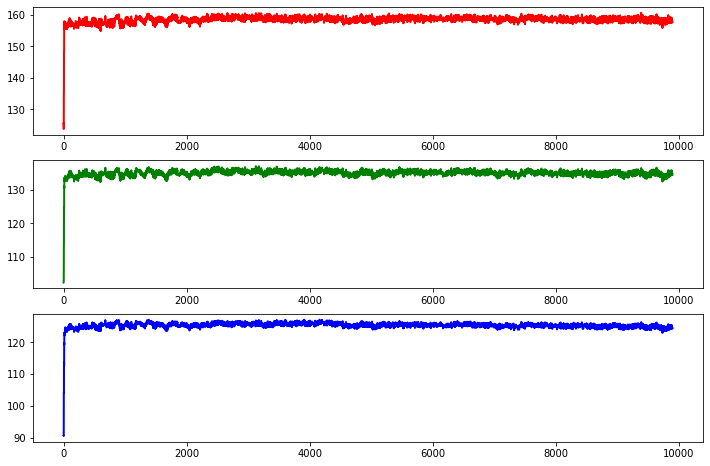

In [8]:
band = [42, 240]
fps = 30

r_signal = []
g_signal = []
b_signal = []
prev_bbox = [0,0,10,10]
curr_bbox = [0,0,10,10]
track_toler = 1
detect_th=0.5
# 얼굴검출 opencv 사용 
detector = cv2.dnn.readNetFromTensorflow('model/face_detector.pb',
                                         'model/face_detector.pbtxt')

times=[]
group=[]
#cap = cv2.VideoCapture(1) # 0: 내장캠 1: 외부캠
#time.sleep(2)

subject=0
file_path="D:\\prlab\\ysg\\rppg\\RPPG-HRV_analysis\images\\"+str(subject)
file_list=glob.glob(os.path.join(file_path,"*.png"))
file_list = natsort.natsorted(file_list,reverse=False)
file_list=file_list[:int(19801/2)]

try:
    for file in file_list:
        test=time.time()
        # group 설정
        g=file.split('\\')[-1].split('_')[1]
        group.append(g)
        # time 설정
        t=file.split('\\')[-1].split('_')[-1][:-4]
        times.append(t)
        # 프레임(img) 가져오기
        print("img path: ",file)
        frame = cv2.imread(file, cv2.IMREAD_COLOR)

        # 현재 프레임에서 얼굴 검출하기
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), [104., 117., 123.], False, False)
        detector.setInput(blob)
        detections = detector.forward()

        h, w = frame.shape[:2]
        bboxes = [detections[0, 0, i, 3:7] for i in range(detections.shape[2]) if detections[0, 0, i, 2] >= detect_th]
        if len(bboxes) > 0:
            bboxes = sorted(bboxes, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]), reverse=True)
            bboxes = [(rect * np.array([w, h, w, h])).astype('int') for rect in bboxes]  # (xs,ys,xe,ye)
            curr_bbox = bboxes[0]
            prev_bbox = curr_bbox
        else:
            curr_bbox = prev_box

        # 얼굴 영역만 잘라내기
        face = frame[curr_bbox[1]:curr_bbox[3], curr_bbox[0]:curr_bbox[2]]

        # remote-PPG 신호 추출하기
        b, g, r = cv2.split(face)
        r_mean = np.mean(r)
        g_mean = np.mean(g)
        b_mean = np.mean(b)
        # 각신호를 담을 list
        r_signal.append(r_mean)
        g_signal.append(g_mean)
        b_signal.append(b_mean)
        t=time.time()-test
        print("이미지하나 실행시간!!!!!!!!!!!!!: ",t)
        # 얼굴 검출 시각화하기
        cv2.rectangle(frame, (curr_bbox[0], curr_bbox[1]), (curr_bbox[2], curr_bbox[3]), (0,0,255), 2)
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) == 27:
            break
            
    
finally:
    cv2.destroyAllWindows()
    print("==================================================!!!finish!!!=================================================")

plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(r_signal, 'r', linewidth=2)
plt.subplot(3,1,2)
plt.plot(g_signal, 'g', linewidth=2)
plt.subplot(3,1,3)
plt.plot(b_signal, 'b', linewidth=2)
plt.show()

In [4]:
len(times)

19801

pulse length:  (9900,)
5분 이미지 실행시간!!!!!!!!!!!!!!!!!!!!!!:  41.872140407562256


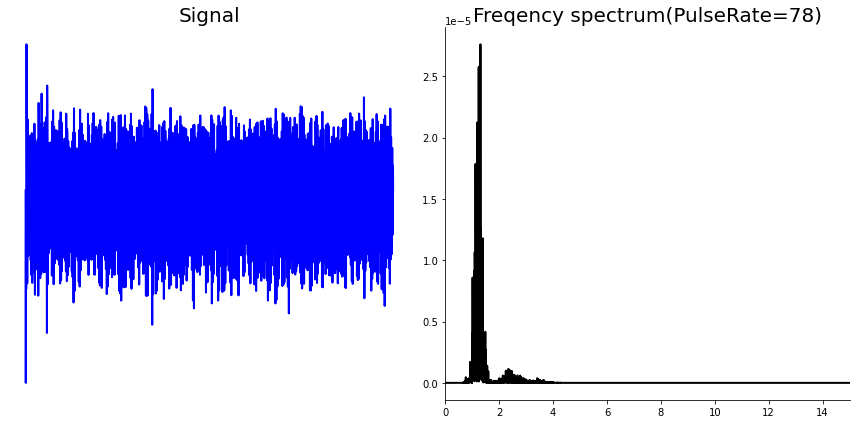

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\rppg\\rppg0.csv'

In [9]:
# CHROM 신호 추출
# chrom이란 움직임에 더 강인하게 하는것.
# 움직임은 r,g,b동일하게발생/ pulse는 r,g,b각각 다름
# 이를 이용해 움직임은 제거하고 pulse만 남기도록.
test=time.time()
#보통 신호는 g,r,b순으로 잘보인다. 
# 심박수를 더 잘보이게 하기위한 후처리
raw_signal = np.array([r_signal, g_signal, b_signal]).transpose() # 1.세개의 신호를 하나로, 하나의신호화
detrended = detrend_signal(raw_signal, fps) # 2.추세제거
detrended = detrended.transpose()
# 3. 2차원으로 prediction  , 수식에 대해서는 자세히 이해 x
X = 3 * detrended[0] - 2 * detrended[1] # 4. detrend [] > 0: r, 1: g, 2: b
Y = 1.5 * detrended[0] + detrended[1] - 1.5 * detrended[2]
# 5. bandpass filtering
Xf = filter_bandpass(X, fps, band)
Yf = filter_bandpass(Y, fps, band)
alpha = np.std(Xf) / np.std(Yf)
# 6. pulse 신호로 계산
pulse = Xf - alpha * Yf
print("pulse length: ",pulse.shape)

# 심박수 (심장) / '맥박수' (혈관) >> 우리는 맥박수를 보는것.
# 맥박수 계산하는 방법
# 1) 시계열 도메인에서 PPI(peak-to-peak interval) 계산  ==> instant pulse-rate
# 2) 주파수 도메인에서 maximum power band 검출 ==> average pulse-rate


# 주파수 스펙트럼 계산
# 실시간에서는 실시간 fs를 계산해서 파라미터로 넣어줘야함
f, psd = signal.periodogram(pulse, fs=30, window='hann')
max_band = np.argmax(psd)
pr = int(f[max_band] * 60) #분당맥박수
pr = min(max(pr, band[0]), band[1])

t=time.time()-test
print('5분 이미지 실행시간!!!!!!!!!!!!!!!!!!!!!!: ', t)
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(pulse, 'b', linewidth=2)    
plt.axis('off')
plt.title('Signal', fontsize=20)

ax = plt.subplot(1,2,2)
plt.plot(f, psd, 'k', linewidth=2)    
plt.xlim([0, 15])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Freqency spectrum(PulseRate={})'.format(pr), fontsize=20)

plt.tight_layout()
plt.show()

file_num=subject
save_path='D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\rppg\\'
f = open(save_path+'rppg'+str(file_num)+'.csv', 'w', newline='')
wr = csv.writer(f)
wr.writerow(pulse)
wr.writerow(times)
wr.writerow(group)
f.close()

# RPPG grouping check

In [ ]:
path="D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\rppg\\rppg11.csv"

In [ ]:
pd.set_option('display.max_rows',None)
data=pd.read_csv(path,header=None)
print(data.columns)
#df=df.transpose()
data=data.transpose()
data.columns=['hr','time','group']
data

In [ ]:
# group 1 > 1초 동안의 frame group
pd.set_option('display.max_rows',None)
groups=data.groupby(data['group'])
print(len(groups))
groups.size()

In [ ]:
# 자세히 확인
i=0
counts=[]
for key,group in groups:
    print("* key",key)
    print("* count",len(group))
    group['sr']=len(group)
    print(group[:])
    counts.append(len(group))
    g=group[:].transpose()
    #g.to_csv("D:\\prlab\\ysg\\rppg\\rppg_HRV\\data\\ppg_data\\rppg(var_sr)\\before\\2\\rppg2_"+str(i)+".csv",header=False,index=False)
    i=i+1